In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [3]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [ ]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5", 
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
} ## 샘플 파일 이름 지정.
adatas = {} ## 샘플 데이터 저장 딕셔너리

## 샘플을 쭉 읽어서 
for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename) ## 각 파일 경로
    sample_adata = sc.read_10x_h5(path) ## 파일을 AnnData 객체로 저장
    sample_adata.var_names_make_unique() ## 변수 이름 중복되지 않게 저장
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/home/younggun0816/anaconda3/envs/GRN/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


s1d1    8785
s1d3    8340
Name: sample, dtype: int64


/home/younggun0816/anaconda3/envs/GRN/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

## Quality Control(품질관리)

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
) ## 3가지를 품질 지표에 포함한다.

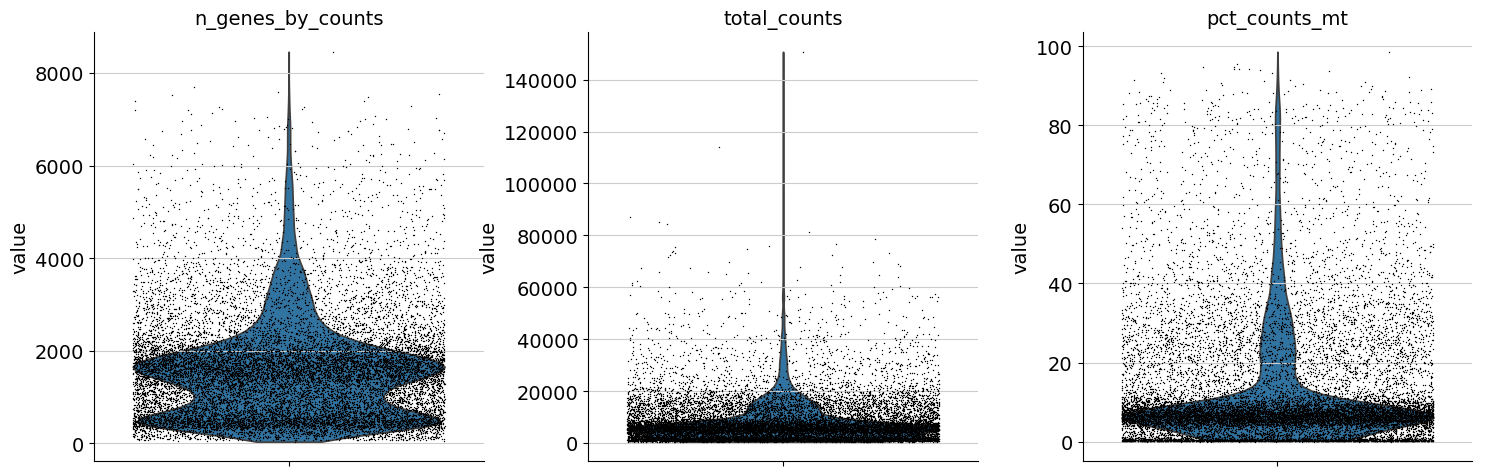

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
) ## 세포마다 검출된 유전자 수, 세포에서 측정된 총 발현량, 미토콘드리아 유전자 발현 비율.

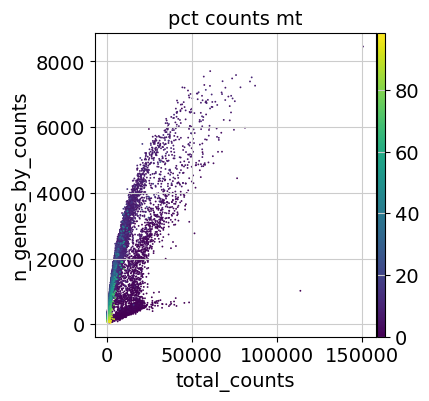

In [ ]:
## 위는 지표 하나씩마다 파악하고, 아래는 지표 간의 관계를 파악한다.
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
## 산점도로 QC 지표 고려. 

In [ ]:
sc.pp.filter_cells(adata, min_genes=100) ## cell에서 gene 작은 값 필터링.
sc.pp.filter_genes(adata, min_cells=3) ## 작은 gene도 필터링.

## Normalization

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
## 방식 선택이 가능하나, 기본값은 "seurat"이다.

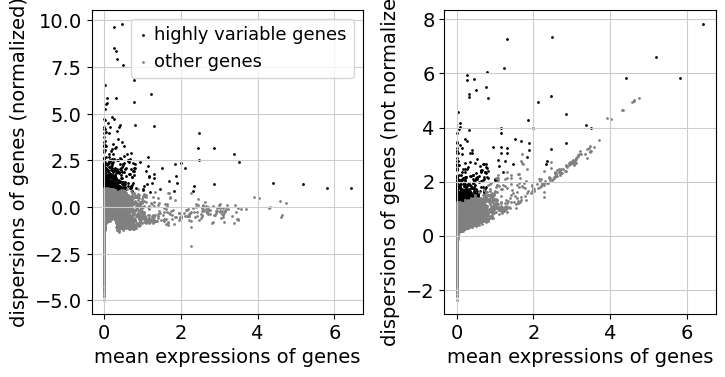

In [ ]:
sc.pl.highly_variable_genes(adata)
## x축은 평균 발현값, y축은 유전자 변동성. 선택된 값이 특정 색상으로 나타난다.

In [14]:
import pandas as pd

file_path = '/home/younggun0816/GRN/GRACE/example/mESC1/GSE98664_tpm_sailfish_mergedGTF_RamDA_mESC_differentiation_time_course.txt'

# 파일의 첫 줄을 확인하여 구분자 파악하기
data = pd.read_csv(file_path, sep='\t')
print(data.head())



           transcript_id  RamDA_mESC_00h_A04  RamDA_mESC_00h_A05  \
0   ENSMUST00000000001.4            14.93640           27.500900   
1  ENSMUST00000000003.13             0.00000            0.000000   
2   ENSMUST00000000010.8             0.00000            0.000000   
3  ENSMUST00000000028.13             5.47754            0.815448   
4  ENSMUST00000000033.11             0.00000            0.000000   

   RamDA_mESC_00h_A06  RamDA_mESC_00h_A07  RamDA_mESC_00h_A08  \
0           18.307100            15.37880            12.83120   
1            0.000000             0.00000             0.00000   
2            0.000000             0.00000             0.00000   
3            0.804286             3.66321             6.65786   
4            0.000000             0.00000             0.00000   

   RamDA_mESC_00h_A09  RamDA_mESC_00h_A12  RamDA_mESC_00h_B01  \
0            29.21980           25.043000            17.23930   
1             0.00000            0.000000             0.00000   
2    

In [15]:
print(data.shape)

(157717, 422)


In [24]:
# 숫자형 데이터와 문자열 데이터 분리
numeric_data = data.drop(columns=['transcript_id']).values.astype(np.float64)  # 숫자 데이터만 추출
transcript_ids = data['transcript_id'].values  # 문자열 데이터 추출


In [25]:
print(numeric_data)
print(transcript_ids)

[[14.9364  27.5009  18.3071  ... 68.8691  55.017   69.823  ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 ...
 [51.6806  19.2678  44.1753  ...  1.21481  1.69008  0.     ]
 [44.9199  10.0754  32.9183  ...  1.20625  0.       0.     ]
 [ 0.       2.44825  2.21755 ...  0.       0.       2.26325]]
['ENSMUST00000000001.4' 'ENSMUST00000000003.13' 'ENSMUST00000000010.8' ...
 'TCONS_00076086' 'TCONS_00076087' 'TCONS_00076088']


In [60]:
import scanpy as sc
# AnnData 객체 생성
adata = sc.AnnData(X=numeric_data)

In [61]:
# transcript_id를 adata.obs에 추가
adata.obs['transcript_id'] = transcript_ids


In [62]:
print(adata)

AnnData object with n_obs × n_vars = 157717 × 421
    obs: 'transcript_id'


In [63]:
sc.pp.filter_genes(adata, min_cells=int(0.1 * adata.shape[0]))
sc.pp.filter_cells(adata, min_genes=int(0.1 * adata.shape[1]))  


In [64]:
print(adata.shape)

(108190, 421)


In [65]:
print(adata.X)

[[14.9364   27.5009   18.3071   ... 68.8691   55.017    69.823   ]
 [ 5.47754   0.815448  0.804286 ...  7.90963   7.22196   7.25139 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [51.6806   19.2678   44.1753   ...  1.21481   1.69008   0.      ]
 [44.9199   10.0754   32.9183   ...  1.20625   0.        0.      ]
 [ 0.        2.44825   2.21755  ...  0.        0.        2.26325 ]]


In [66]:
print(adata)

AnnData object with n_obs × n_vars = 108190 × 421
    obs: 'transcript_id', 'n_genes'
    var: 'n_cells'


In [67]:
adata_TPM = sc.pp.log1p(adata, copy=True)

In [68]:
# 2. 정규화 및 변환
# TPM 및 CPM 정규화 (Scanpy는 기본적으로 counts per million을 적용함)
adata_CPM = sc.pp.normalize_total(adata, target_sum=1e6, copy=True)
# 로그 변환
sc.pp.log1p(adata_CPM)

In [69]:
from statsmodels.stats.multitest import multipletests

In [70]:
print(adata_CPM)

AnnData object with n_obs × n_vars = 108190 × 421
    obs: 'transcript_id', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'
